In [165]:
from graphviz import Digraph
import torch
def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [249]:
import math
class Value:
    def __init__(self, value, _children=(), label="", _op=""):
        self.data = value
        self._prev = _children
        self._backward = lambda: None
        self.label=label
        self._op = _op
        self.grad = 0.0
        
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x))/(math.exp(x) + math.exp(-x))
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1))
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self, ), f'e**{self.data}')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def log(self):
        out = Value(math.log(self.data), (self, ), f'log({self.data})')

        def _backward():
            self.grad += 1 / self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(Value(other))
        
    def __repr__(self):
         return str(f'Value: {self.data}')
    def __str__(self):
        return str(f'Value :{self.data}')

In [250]:
Value(3.0).tanh()

Value: 0.9950547536867306

In [251]:
Value(10.0).exp()

Value: 22026.465794806718

In [252]:
Value(10.0).log()

Value: 2.302585092994046

In [233]:
a = Value(3.0)
a.label = 'a'
b = Value(2.0)
b.label = 'b'

e = Value(5.0, label='e')
f = Value(6.0, label='f')
d = e + f
d.label = 'd'
c = a * b
c.label = 'c'

h = c*d
h.label= 'h'
g = c**2 + h
g.label = 'g'

In [226]:
g

Value: 102.0

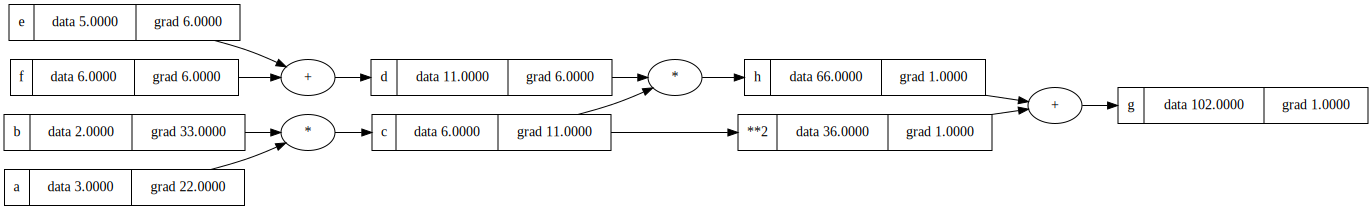

In [230]:
draw_dot(g)

In [228]:
g.grad = 1
g._backward()

In [229]:
h._backward()
d._backward()
c._backward()